   event_id                                               sent  \
0      4000  Event(target=OpNode(ComposeReview, InvokeMetho...   
1      4001  Event(target=OpNode(ComposeReview, InvokeMetho...   
2      4002  Event(target=OpNode(ComposeReview, InvokeMetho...   
3      4003  Event(target=OpNode(ComposeReview, InvokeMetho...   
4      4004  Event(target=OpNode(ComposeReview, InvokeMetho...   

               sent_t                                                ret  \
0  (2, 1740235655857)  EventResult(event_id=4000, result=[], metadata...   
1  (2, 1740235655857)  EventResult(event_id=4001, result=[], metadata...   
2  (2, 1740235655857)  EventResult(event_id=4002, result=[], metadata...   
3  (2, 1740235655857)  EventResult(event_id=4003, result=[], metadata...   
4  (2, 1740235655857)  EventResult(event_id=4004, result=[], metadata...   

                ret_t  roundtrip  flink_time  \
0  (2, 1740235656291)   0.429930    0.229199   
1  (2, 1740235656309)   0.445587    0.380347   
2 

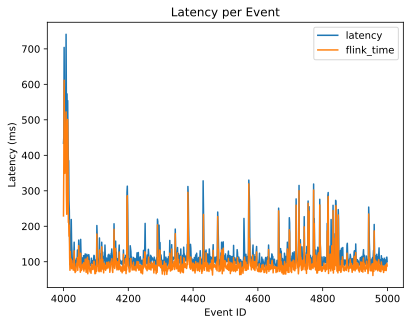

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_pickle('test2.pkl')

# Display the first few rows of the dataframe to understand its structure
print(df.head())

df.plot(x='event_id', y=['latency', 'flink_time'], kind='line')
plt.xlabel('Event ID')
plt.ylabel('Latency (ms)')
# plt.yscale('log')
plt.title('Latency per Event')
plt.show()

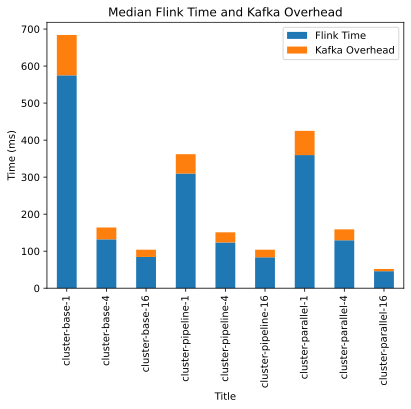

In [ ]:
def preprocess_data(pickle_file_path):
    # Read the DataFrame from the pickle file
    df = pd.read_pickle(pickle_file_path)

    # Ignore the first 10 events
    df = df.iloc[10:]
    
    # Calculate the additional Kafka overhead
    df['kafka_overhead'] = df['latency'] - df['flink_time']

    # Extract median values from df
    flink_time_median = df['flink_time'].median()
    latency_median = df['latency'].median()

    return {
        'flink_time_median': flink_time_median,
        'kafka_overhead_median': latency_median - flink_time_median
    }


titles = ['cluster-base-1', 'cluster-base-4','cluster-base-16', 'cluster-pipeline-1', 'cluster-pipeline-4', 'cluster-pipeline-16', 'cluster-parallel-1', 'cluster-parallel-4', 'cluster-parallel-16']
pickle_files = ['cluster_base1.pkl','cluster_base4.pkl',  'cluster_base16.pkl', 'cluster_pipe_1.pkl', 'cluster_pipe_4.pkl', 'cluster_pipe_16.pkl', 'cluster_p1.pkl','cluster_p4.pkl', 'cluster_p16.pkl']

# Process each file and collect median data
all_median_data = []
for title, file in zip(titles, pickle_files):
    median_values = preprocess_data(file)
    all_median_data.append({
        'Metric': 'Flink Time',
        'Value': median_values['flink_time_median'],
        'Title': title
    })
    all_median_data.append({
        'Metric': 'Kafka Overhead',
        'Value': median_values['kafka_overhead_median'],
        'Title': title
    })

all_median_df = pd.DataFrame(all_median_data)

# Use the order defined by the titles variable
sorted_titles = titles

# Pivot the DataFrame and reindex to maintain sorted order
pivot_df = (
    all_median_df.pivot(index='Title', columns='Metric', values='Value')
    .reindex(sorted_titles)
)

# Plot
fig, ax = plt.subplots()
pivot_df.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax)
plt.ylabel('Time (ms)')
plt.title('Median Flink Time and Kafka Overhead')
plt.legend(['Flink Time', 'Kafka Overhead'])
plt.show()
